In [1]:
!pip3 install wordninja==2.0.0             # for splitting joined words
!pip3 install scikit-learn==0.22.2         # for one-hot encoding
!pip3 install lime==0.2.0                  # for explaining model predictions
!pip3 install tensorflow

In [3]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
import tensorflow as tf
# Check if any GPU is detected
print("Is GPU available: ", tf.test.is_gpu_available())
print("GPU(s) found: ")
print(tf.config.experimental.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available:  False
GPU(s) found: 
[]


In [5]:
# data = pd.read_csv("/content/drive/My Drive/3359 project/COMP_3359_GROUP8-main/data/train.csv")

In [4]:
data_path = os.getcwd().replace('script', 'data')
print(data_path)
glove_path = data_path + '/glove.6B.50d.txt'
print(glove_path)

/Users/zhuzeyu/Desktop/COMP3359/Project/COMP__3359__GROUP8/data
/Users/zhuzeyu/Desktop/COMP3359/Project/COMP__3359__GROUP8/data/glove.6B.50d.txt


In [8]:
data = pd.read_pickle(data_path + '/sentiment_data.pkl.zip')
data["label"] = data["label"].str[9:10]
data.head()

,label,text
0,2,xcellent home help for parents: Volume 1 of Do...
1,1,"tay far, far away.: I made it through about 6,..."
2,1,ost Woods: Lost WoodsI didn't really understan...
3,1,"enaissance -12, Women's brown suead shoes: Rec..."
4,2,est Novel I've Read This Year: Intrigued by th...


In [7]:
data=data.sample(frac=0.01, replace=False, random_state=1).reset_index().drop(columns = ["index"])

In [9]:
from string import punctuation
from collections import defaultdict
import numpy as np

def load_embedding_from_disks(glove_filename, with_indexes=True):
    """
    Read a GloVe txt file. If `with_indexes=True`, we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
    else:
        word_to_embedding_dict = dict()

    
    with open(glove_filename, 'r') as glove_file:
        for (i, line) in enumerate(glove_file):
            
            split = line.split(' ')
            
            word = split[0]
            
            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )
            
            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    _WORD_NOT_FOUND = [0.0]* len(representation)  # Empty representation for unknown words.
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict


def sentence_to_word_ids(sentence, word_to_index):
    """
    Note: there might be a better way to split sentences for GloVe.
    Please look at the documentation or open an issue to suggest a fix.
    """
    # Separating punctuation from words:
    for punctuation_character in punctuation:
        sentence = sentence.replace(punctuation_character, " {} ".format(punctuation_character))
    # Removing double spaces and lowercasing:
    sentence = sentence.replace("  ", " ").replace("  ", " ").lower().strip()
    # Splitting on every space:
    split_sentence = sentence.split(" ")
    # Converting to IDs:
    ids = [word_to_index[w.strip()] for w in split_sentence]
    return ids, split_sentence

In [10]:
word_to_index_dict, index_to_embedding_array = load_embedding_from_disks(glove_path, with_indexes=True)
index_to_embedding_array.shape

(400002, 50)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = data['text'].to_numpy()
y_beforelabel = data['label'].to_numpy()
le_y = preprocessing.LabelEncoder()
oe_y = preprocessing.OneHotEncoder()
temp_y = le_y.fit_transform(y_beforelabel).reshape(-1, 1)
X_train, X_traindev, temp_y_train, temp_y_traindev = train_test_split(X, temp_y, test_size=0.2, random_state=42)
y_train = oe_y.fit_transform(temp_y_train).toarray()
y_traindev = oe_y.fit_transform(temp_y_traindev).toarray()

In [14]:
X_train

array(["OW!!! Incredible!!!: This was the first novel I ever read of L.Spencer's,to say the least this book had me hooked from the beginning. Ms.Spencer has an incredible talent!Her description of the scenery made me feel as if I my self have been to Camden. Since I first read this book, a year and a half ago, I have since read 13 other novels by her.She is a very gifted woman. I highly recommend this book as well as all her others,",
       'O NOT WASTE YOUR MONEY!!!: This guide tells you absolutely nothing except to go online for more info. Load of crap. If I wanted an online guide I would not have bought a paper one. This is a waste of your money AND your time. BUYER BEWARE!!',
       "ery Disappointing: The product was delivered quickly and was well packaged, to be fair. I plugged it in for charging and, after a full day, it still couldn't completely remove a cork from a wine bottle (it made about three revolutions before dying). I plugged it in again for another day and still had 

In [18]:
def make_complete(x):
    #length = max(map(len, x))
    length = 400
    return np.array([xi+[0]*(length-len(xi)) for xi in x])

In [19]:
X_train_token = make_complete( sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_train  )
X_traindev_token = make_complete([ sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_traindev ])

In [20]:
X_train_token

array([[ 66125,    805,    805, ...,      0,      0,      0],
       [  4868,     36,   3631, ...,      0,      0,      0],
       [231239,   5407,     45, ...,      0,      0,      0],
       ...,
       [   524,   6521,   2853, ...,      0,      0,      0],
       [ 20506,   6712,     45, ...,      0,      0,      0],
       [  1343,     57,   1534, ...,      0,      0,      0]])

In [21]:
BATCH_SIZE = 128
# Training set data pipeline
train_ds_glove = tf.data.Dataset.from_tensor_slices((X_train_token, y_train))   
train_ds_glove = train_ds_glove.shuffle(buffer_size=len(X_train_token))                
train_ds_glove = train_ds_glove.batch(batch_size=BATCH_SIZE)                     
# Test set data pipeline
traindev_ds_glove = tf.data.Dataset.from_tensor_slices((X_traindev_token, y_traindev))
traindev_ds_glove = traindev_ds_glove.batch(batch_size=BATCH_SIZE)

In [22]:
""" Constructing Model with Pre-Trained Word Embedding """

# Get description of word embedding
vocab_size, embedding_dim = index_to_embedding_array.shape
print("Vocab Size: ", vocab_size)
print("Embedding Dim: ", embedding_dim)

# Construct embedding layer and use embedding vectors to set weights.
# Set trainable=False to freeze the weights to prevent weight to be 
# changed during training.
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, 
                                            output_dim=embedding_dim,
                                            weights=[index_to_embedding_array],
                                            trainable=False)

# Construct model using the pre-trained embedding layer.
# This model learns by changing network weights in Dense layer.
# (no trainable weights in GlobalAveragePooling layer)
model_glove = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
print(model_glove.summary())

# Compile model
model_glove.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(1e-2),
                    metrics=['accuracy'])

# Train model
history = model_glove.fit(train_ds_glove, epochs=30,
                          validation_data=traindev_ds_glove, 
                          validation_steps=30,
                          verbose=1)

Vocab Size:  400002
Embedding Dim:  50
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          20000100  
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 52        
Total params: 20,001,427
Trainable params: 1,327
Non-trainable params: 20,000,100
_________________________________________________________________
None
Epoch 1/30
1575/1575 [==============================] - 14s 7ms/step - loss: 0.6364 - accuracy: 0.6306 - val_loss: 0.5316 - val_accuracy: 0.7404
Epoch 2/30
1575/1575 [===========================

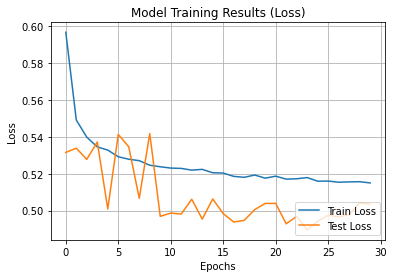

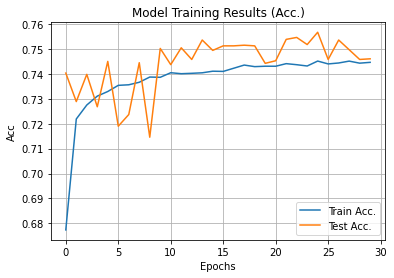

In [23]:

##### Loss #####
# Get training results
history_dict = history.history
train_loss = history_dict['loss']
test_loss = history_dict['val_loss']

# Plot training results
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

# Show plot
plt.title('Model Training Results (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### Accuracy #####
# Get training results
history_dict = history.history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

# Plot training results
plt.plot(train_acc, label='Train Acc.')
plt.plot(test_acc, label='Test Acc.')

# Show plot
plt.title('Model Training Results (Acc.)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc="lower right")
plt.grid()

In [28]:

# prediction example
from scipy import stats
no = 10
example = X_train[no]
corresponding_output = y_train[no]

print("Sentence: \n",
      example, "\n")
ids = sentence_to_word_ids(example, word_to_index_dict)[0]
print("Corresponding ids: \n",
      ids, "\n")
predictions = np.amin(model_glove.predict(ids), axis=0)
print("Corresponding predictions: \n",
      predictions, "\n")
print("Final prediction: \n", 
      le_y.inverse_transform(stats.mode(predictions)[0].astype(int))[0], "\n")
print("Actual categorization: \n", 
     list(le_y.classes_)[oe_y.inverse_transform([corresponding_output])[0][0]])

Sentence: 
 mazing value for the price: I have a small home-based business - didn't want to pop for a laser printer, but needed something that created quality prints for major presentations. This machine is AWESOME. Fast copies, fast printing, easy to set up and operate (I barely needed the directions).Love it. 

Corresponding ids: 
 [400001, 1158, 10, 0, 626, 45, 41, 33, 7, 357, 163, 11, 243, 258, 11, 73330, 57, 2159, 303, 4, 2564, 10, 7, 8013, 13568, 1, 34, 911, 645, 12, 955, 1506, 10470, 10, 224, 14448, 2, 37, 2358, 14, 13602, 2, 1605, 3638, 1, 1605, 7078, 1, 1673, 4, 208, 60, 5, 3189, 23, 41, 4236, 911, 0, 6975, 24, 2, 835, 20, 2] 

Corresponding predictions: 
 [0.000000e+00 7.496192e-18] 

Final prediction: 
 1 

Actual categorization: 
 2
